In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import random # we don't fix seed here so can use to re sample test patients

Global seed set to 0


In [2]:
import seaborn as sns

In [3]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


In [4]:
sc.set_figure_params(dpi=100, frameon=False)

# Read data

In [5]:
# adt.h5ad is full dataset, change to adt_test.h5ad for a smaller subset
adt = sc.read('data/haniffa-2021/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 624325 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [6]:
# rna.h5ad is full dataset, change to rna_test.h5ad for a smaller subset
rna = sc.read('data/haniffa-2021/rna.h5ad')
rna

AnnData object with n_obs × n_vars = 624325 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [7]:
# rna = rna[:, rna.var.index[:2000]]

In [8]:
idx = adt.obs['patient_id'].sort_values().index # need to sort by patient for the data loader

In [9]:
adt = adt[idx].copy()
rna = rna[idx].copy()

# MIL

In [10]:
# arange modality adatas into one adata
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],
    groups = [[0], [0]],
    layers = [['count'], [None]],
)
adata

AnnData object with n_obs × n_vars = 624325 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [11]:
# if want to leave out patients as test uncomment the next two cells
number_of_test_patients = 15
patients = list(adata.obs['patient_id'].cat.categories)
# test_patient_ids = random.sample(patients, number_of_test_patients)
test_patient_ids = ['CV0137',
 'MH9143271',
 'CV0068',
 'CV0201',
 'newcastle65',
 'CV0050',
 'MH9143371',
 'CV0176',
 'MH9143275',
 'MH9179825',
 'MH9143326',
 'CV0073',
 'CV0257',
 'newcastle21',
 'AP12']

adata[adata.obs.patient_id.isin(test_patient_ids)].obs[['Status_on_day_collection_summary', 'patient_id']].drop_duplicates().groupby('Status_on_day_collection_summary').count() # check class distribution for test set

,patient_id
Status_on_day_collection_summary,
Asymptomatic,1
Critical,3
Healthy,1
Mild,3
Moderate,6
Severe,1


In [12]:
# subset
adata_test = adata[adata.obs.patient_id.isin(test_patient_ids)].copy()
adata = adata[~adata.obs.patient_id.isin(test_patient_ids)].copy()

In [13]:
mtg.model.MultiVAE_MIL.setup_anndata(
            adata, 
            class_label="Status_on_day_collection_summary",
            rna_indices_end=4000,
            categorical_covariate_keys=['Sex', 'Age_interval', 'patient_id',"Smoker"],
            continuous_covariate_keys=None,)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 536388 cells, 4192 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 5 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [14]:
mil = mtg.model.MultiVAE_MIL(
            adata, 
            modality_lengths=[4000, 192],
            losses=['nb', 'mse'],
            loss_coefs={'kl': 0.0001, 'integ': 0},
            class_label='Status_on_day_collection_summary',
            patient_label='patient_id',
            scoring='gated_attn', # or 'attn'
            class_layers=2,
            add_patient_to_classifier=False, # whether to use patient embeddings for classification
            hierarchical_attn=False, # whether to have hierarchical attention or just cell attention,

        )

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [15]:
mil.train(max_epochs=150, 
    batch_size=256, n_epochs_kl_warmup=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/150:   1%|          | 1/150 [00:29<1:11:44, 28.89s/it, loss=752, v_num=1]

Metric elbo_validation improved. New best score: 710.660


Epoch 2/150:   1%|▏         | 2/150 [00:58<1:11:59, 29.19s/it, loss=600, v_num=1]

Metric elbo_validation improved by 114.771 >= min_delta = 0.0. New best score: 595.889


Epoch 3/150:   2%|▏         | 3/150 [01:26<1:10:33, 28.80s/it, loss=613, v_num=1]

Metric elbo_validation improved by 31.655 >= min_delta = 0.0. New best score: 564.234


Epoch 4/150:   3%|▎         | 4/150 [01:55<1:09:33, 28.59s/it, loss=575, v_num=1]

Metric elbo_validation improved by 17.516 >= min_delta = 0.0. New best score: 546.718


Epoch 5/150:   3%|▎         | 5/150 [02:24<1:09:54, 28.93s/it, loss=554, v_num=1]

Metric elbo_validation improved by 13.915 >= min_delta = 0.0. New best score: 532.803


Epoch 6/150:   4%|▍         | 6/150 [02:53<1:09:43, 29.05s/it, loss=548, v_num=1]

Metric elbo_validation improved by 11.677 >= min_delta = 0.0. New best score: 521.127


Epoch 7/150:   5%|▍         | 7/150 [03:23<1:09:38, 29.22s/it, loss=513, v_num=1]

Metric elbo_validation improved by 11.282 >= min_delta = 0.0. New best score: 509.845


Epoch 8/150:   5%|▌         | 8/150 [03:53<1:09:26, 29.34s/it, loss=537, v_num=1]

Metric elbo_validation improved by 6.938 >= min_delta = 0.0. New best score: 502.908


Epoch 9/150:   6%|▌         | 9/150 [04:22<1:08:38, 29.21s/it, loss=518, v_num=1]

Metric elbo_validation improved by 4.087 >= min_delta = 0.0. New best score: 498.821


Epoch 10/150:   7%|▋         | 10/150 [04:50<1:07:16, 28.83s/it, loss=488, v_num=1]

Metric elbo_validation improved by 3.838 >= min_delta = 0.0. New best score: 494.982


Epoch 11/150:   7%|▋         | 11/150 [05:17<1:05:58, 28.48s/it, loss=508, v_num=1]

Metric elbo_validation improved by 4.441 >= min_delta = 0.0. New best score: 490.541


Epoch 12/150:   8%|▊         | 12/150 [05:47<1:06:04, 28.73s/it, loss=509, v_num=1]

Metric elbo_validation improved by 1.837 >= min_delta = 0.0. New best score: 488.705


Epoch 13/150:   9%|▊         | 13/150 [06:16<1:06:06, 28.96s/it, loss=493, v_num=1]

Metric elbo_validation improved by 3.773 >= min_delta = 0.0. New best score: 484.932


Epoch 14/150:   9%|▉         | 14/150 [06:46<1:05:59, 29.11s/it, loss=518, v_num=1]

Metric elbo_validation improved by 2.432 >= min_delta = 0.0. New best score: 482.500


Epoch 15/150:  10%|█         | 15/150 [07:15<1:05:42, 29.20s/it, loss=510, v_num=1]

Metric elbo_validation improved by 1.682 >= min_delta = 0.0. New best score: 480.818


Epoch 16/150:  11%|█         | 16/150 [07:44<1:05:27, 29.31s/it, loss=491, v_num=1]

Metric elbo_validation improved by 1.658 >= min_delta = 0.0. New best score: 479.160


Epoch 17/150:  11%|█▏        | 17/150 [08:14<1:04:51, 29.26s/it, loss=478, v_num=1]

Metric elbo_validation improved by 2.051 >= min_delta = 0.0. New best score: 477.109


Epoch 18/150:  12%|█▏        | 18/150 [08:42<1:03:47, 29.00s/it, loss=494, v_num=1]

Metric elbo_validation improved by 1.770 >= min_delta = 0.0. New best score: 475.339


Epoch 19/150:  13%|█▎        | 19/150 [09:11<1:03:21, 29.02s/it, loss=482, v_num=1]

Metric elbo_validation improved by 1.433 >= min_delta = 0.0. New best score: 473.906


Epoch 20/150:  13%|█▎        | 20/150 [09:39<1:02:26, 28.82s/it, loss=516, v_num=1]

Metric elbo_validation improved by 1.089 >= min_delta = 0.0. New best score: 472.817


Epoch 21/150:  14%|█▍        | 21/150 [10:08<1:01:28, 28.59s/it, loss=501, v_num=1]

Metric elbo_validation improved by 1.612 >= min_delta = 0.0. New best score: 471.205


Epoch 22/150:  15%|█▍        | 22/150 [10:36<1:01:13, 28.70s/it, loss=505, v_num=1]

Metric elbo_validation improved by 1.189 >= min_delta = 0.0. New best score: 470.016


Epoch 23/150:  15%|█▌        | 23/150 [11:06<1:01:08, 28.89s/it, loss=499, v_num=1]

Metric elbo_validation improved by 0.431 >= min_delta = 0.0. New best score: 469.585


Epoch 24/150:  16%|█▌        | 24/150 [11:35<1:00:58, 29.04s/it, loss=479, v_num=1]

Metric elbo_validation improved by 1.446 >= min_delta = 0.0. New best score: 468.139


Epoch 25/150:  17%|█▋        | 25/150 [12:04<1:00:20, 28.97s/it, loss=488, v_num=1]

Metric elbo_validation improved by 0.879 >= min_delta = 0.0. New best score: 467.260


Epoch 26/150:  17%|█▋        | 26/150 [12:32<59:22, 28.73s/it, loss=460, v_num=1]  

Metric elbo_validation improved by 0.603 >= min_delta = 0.0. New best score: 466.657


Epoch 27/150:  18%|█▊        | 27/150 [13:00<58:26, 28.51s/it, loss=483, v_num=1]

Metric elbo_validation improved by 0.872 >= min_delta = 0.0. New best score: 465.786


Epoch 28/150:  19%|█▊        | 28/150 [13:28<57:28, 28.26s/it, loss=513, v_num=1]

Metric elbo_validation improved by 0.973 >= min_delta = 0.0. New best score: 464.812


Epoch 29/150:  19%|█▉        | 29/150 [13:56<56:36, 28.07s/it, loss=483, v_num=1]

Metric elbo_validation improved by 0.686 >= min_delta = 0.0. New best score: 464.126


Epoch 30/150:  20%|██        | 30/150 [14:24<56:21, 28.18s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.361 >= min_delta = 0.0. New best score: 463.765


Epoch 31/150:  21%|██        | 31/150 [14:52<55:38, 28.06s/it, loss=474, v_num=1]

Metric elbo_validation improved by 0.851 >= min_delta = 0.0. New best score: 462.914


Epoch 32/150:  21%|██▏       | 32/150 [15:19<54:55, 27.93s/it, loss=482, v_num=1]

Metric elbo_validation improved by 1.160 >= min_delta = 0.0. New best score: 461.754


Epoch 34/150:  23%|██▎       | 34/150 [16:16<54:31, 28.21s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.452 >= min_delta = 0.0. New best score: 461.302


Epoch 35/150:  23%|██▎       | 35/150 [16:46<55:01, 28.71s/it, loss=481, v_num=1]

Metric elbo_validation improved by 0.854 >= min_delta = 0.0. New best score: 460.448


Epoch 37/150:  25%|██▍       | 37/150 [17:45<54:55, 29.16s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.994 >= min_delta = 0.0. New best score: 459.454


Epoch 38/150:  25%|██▌       | 38/150 [18:14<54:17, 29.09s/it, loss=493, v_num=1]

Metric elbo_validation improved by 0.171 >= min_delta = 0.0. New best score: 459.283


Epoch 39/150:  26%|██▌       | 39/150 [18:44<54:08, 29.27s/it, loss=461, v_num=1]

Metric elbo_validation improved by 0.899 >= min_delta = 0.0. New best score: 458.384


Epoch 41/150:  27%|██▋       | 41/150 [19:43<53:36, 29.51s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.453 >= min_delta = 0.0. New best score: 457.931


Epoch 42/150:  28%|██▊       | 42/150 [20:12<52:39, 29.25s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.201 >= min_delta = 0.0. New best score: 457.730


Epoch 43/150:  29%|██▊       | 43/150 [20:41<52:13, 29.28s/it, loss=482, v_num=1]

Metric elbo_validation improved by 0.164 >= min_delta = 0.0. New best score: 457.566


Epoch 44/150:  29%|██▉       | 44/150 [21:11<51:48, 29.32s/it, loss=486, v_num=1]

Metric elbo_validation improved by 0.864 >= min_delta = 0.0. New best score: 456.702


Epoch 45/150:  30%|███       | 45/150 [21:40<51:21, 29.34s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.214 >= min_delta = 0.0. New best score: 456.488


Epoch 48/150:  32%|███▏      | 48/150 [23:09<50:20, 29.62s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.832 >= min_delta = 0.0. New best score: 455.657


Epoch 49/150:  33%|███▎      | 49/150 [23:39<49:56, 29.67s/it, loss=485, v_num=1]

Metric elbo_validation improved by 0.161 >= min_delta = 0.0. New best score: 455.496


Epoch 50/150:  33%|███▎      | 50/150 [24:09<49:36, 29.76s/it, loss=471, v_num=1]

Metric elbo_validation improved by 0.055 >= min_delta = 0.0. New best score: 455.440


Epoch 52/150:  35%|███▍      | 52/150 [25:09<48:42, 29.82s/it, loss=478, v_num=1]

Metric elbo_validation improved by 0.381 >= min_delta = 0.0. New best score: 455.059


Epoch 54/150:  36%|███▌      | 54/150 [26:08<47:41, 29.81s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.157 >= min_delta = 0.0. New best score: 454.902


Epoch 55/150:  37%|███▋      | 55/150 [26:38<47:03, 29.72s/it, loss=437, v_num=1]

Metric elbo_validation improved by 0.343 >= min_delta = 0.0. New best score: 454.559


Epoch 56/150:  37%|███▋      | 56/150 [27:07<46:11, 29.48s/it, loss=482, v_num=1]

Metric elbo_validation improved by 0.367 >= min_delta = 0.0. New best score: 454.192


Epoch 57/150:  38%|███▊      | 57/150 [27:34<44:52, 28.95s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.026 >= min_delta = 0.0. New best score: 454.167


Epoch 58/150:  39%|███▊      | 58/150 [28:02<43:40, 28.49s/it, loss=450, v_num=1]

Metric elbo_validation improved by 0.206 >= min_delta = 0.0. New best score: 453.960


Epoch 59/150:  39%|███▉      | 59/150 [28:31<43:38, 28.78s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.580 >= min_delta = 0.0. New best score: 453.380


Epoch 61/150:  41%|████      | 61/150 [29:30<43:05, 29.05s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.292 >= min_delta = 0.0. New best score: 453.088


Epoch 62/150:  41%|████▏     | 62/150 [29:59<42:43, 29.13s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.234 >= min_delta = 0.0. New best score: 452.855


Epoch 64/150:  43%|████▎     | 64/150 [30:56<41:06, 28.68s/it, loss=461, v_num=1]

Metric elbo_validation improved by 0.212 >= min_delta = 0.0. New best score: 452.642


Epoch 66/150:  44%|████▍     | 66/150 [31:52<39:42, 28.36s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.085 >= min_delta = 0.0. New best score: 452.558


Epoch 67/150:  45%|████▍     | 67/150 [32:20<39:05, 28.25s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 452.470


Epoch 69/150:  46%|████▌     | 69/150 [33:16<37:54, 28.08s/it, loss=472, v_num=1]

Metric elbo_validation improved by 0.668 >= min_delta = 0.0. New best score: 451.803


Epoch 74/150:  49%|████▉     | 74/150 [35:39<36:24, 28.75s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.104 >= min_delta = 0.0. New best score: 451.699


Epoch 75/150:  50%|█████     | 75/150 [36:08<36:10, 28.94s/it, loss=470, v_num=1]

Metric elbo_validation improved by 0.270 >= min_delta = 0.0. New best score: 451.428


Epoch 76/150:  51%|█████     | 76/150 [36:38<35:51, 29.07s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.337 >= min_delta = 0.0. New best score: 451.092


Epoch 82/150:  55%|█████▍    | 82/150 [39:33<33:02, 29.15s/it, loss=472, v_num=1]

Metric elbo_validation improved by 0.088 >= min_delta = 0.0. New best score: 451.004


Epoch 84/150:  56%|█████▌    | 84/150 [40:29<31:23, 28.54s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.168 >= min_delta = 0.0. New best score: 450.836


Epoch 85/150:  57%|█████▋    | 85/150 [40:58<31:04, 28.68s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.487 >= min_delta = 0.0. New best score: 450.348


Epoch 89/150:  59%|█████▉    | 89/150 [42:50<28:32, 28.08s/it, loss=447, v_num=1]

Metric elbo_validation improved by 0.523 >= min_delta = 0.0. New best score: 449.826


Epoch 94/150:  63%|██████▎   | 94/150 [45:10<26:12, 28.09s/it, loss=440, v_num=1]

Metric elbo_validation improved by 0.195 >= min_delta = 0.0. New best score: 449.631


Epoch 99/150:  66%|██████▌   | 99/150 [47:39<25:05, 29.51s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.073 >= min_delta = 0.0. New best score: 449.558


Epoch 101/150:  67%|██████▋   | 101/150 [48:38<24:10, 29.61s/it, loss=490, v_num=1]

Metric elbo_validation improved by 0.597 >= min_delta = 0.0. New best score: 448.961


Epoch 104/150:  69%|██████▉   | 104/150 [50:07<22:40, 29.57s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.068 >= min_delta = 0.0. New best score: 448.893


Epoch 112/150:  75%|███████▍  | 112/150 [54:05<18:53, 29.82s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.189 >= min_delta = 0.0. New best score: 448.703


Epoch 116/150:  77%|███████▋  | 116/150 [56:04<16:50, 29.72s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.002 >= min_delta = 0.0. New best score: 448.701


Epoch 117/150:  78%|███████▊  | 117/150 [56:34<16:18, 29.65s/it, loss=450, v_num=1]

Metric elbo_validation improved by 0.388 >= min_delta = 0.0. New best score: 448.313


Epoch 121/150:  81%|████████  | 121/150 [58:32<14:19, 29.62s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.007 >= min_delta = 0.0. New best score: 448.306


Epoch 127/150:  85%|████████▍ | 127/150 [1:01:29<11:13, 29.28s/it, loss=453, v_num=1]

Metric elbo_validation improved by 0.136 >= min_delta = 0.0. New best score: 448.170


Epoch 130/150:  87%|████████▋ | 130/150 [1:02:53<09:28, 28.43s/it, loss=464, v_num=1]

Metric elbo_validation improved by 0.007 >= min_delta = 0.0. New best score: 448.163


Epoch 132/150:  88%|████████▊ | 132/150 [1:03:48<08:25, 28.06s/it, loss=474, v_num=1]

Metric elbo_validation improved by 0.058 >= min_delta = 0.0. New best score: 448.106


Epoch 133/150:  89%|████████▊ | 133/150 [1:04:17<07:58, 28.14s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.401 >= min_delta = 0.0. New best score: 447.704


Epoch 148/150:  99%|█████████▊| 148/150 [1:11:27<00:55, 27.83s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.666 >= min_delta = 0.0. New best score: 447.038


Epoch 150/150: 100%|██████████| 150/150 [1:12:26<00:00, 28.98s/it, loss=451, v_num=1]


In [16]:
# save the model

In [17]:
mil.save("ref_hanifa_4k_wo_hirarchy")

In [18]:
mil_out = mil.get_latent_representation(batch_size=256)
latent, cell_attn, cov_attn, _ = mil_out

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [19]:
adata.obsm['latent'] = latent
adata.obs['cell_attn'] = cell_attn

In [20]:
# subsmaple the data for visualizaion 

In [21]:
adata_ss = sc.pp.subsample(adata, fraction=0.05, copy=True)

In [22]:
sc.pp.neighbors(adata_ss, use_rep='latent')
sc.tl.umap(adata_ss)

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


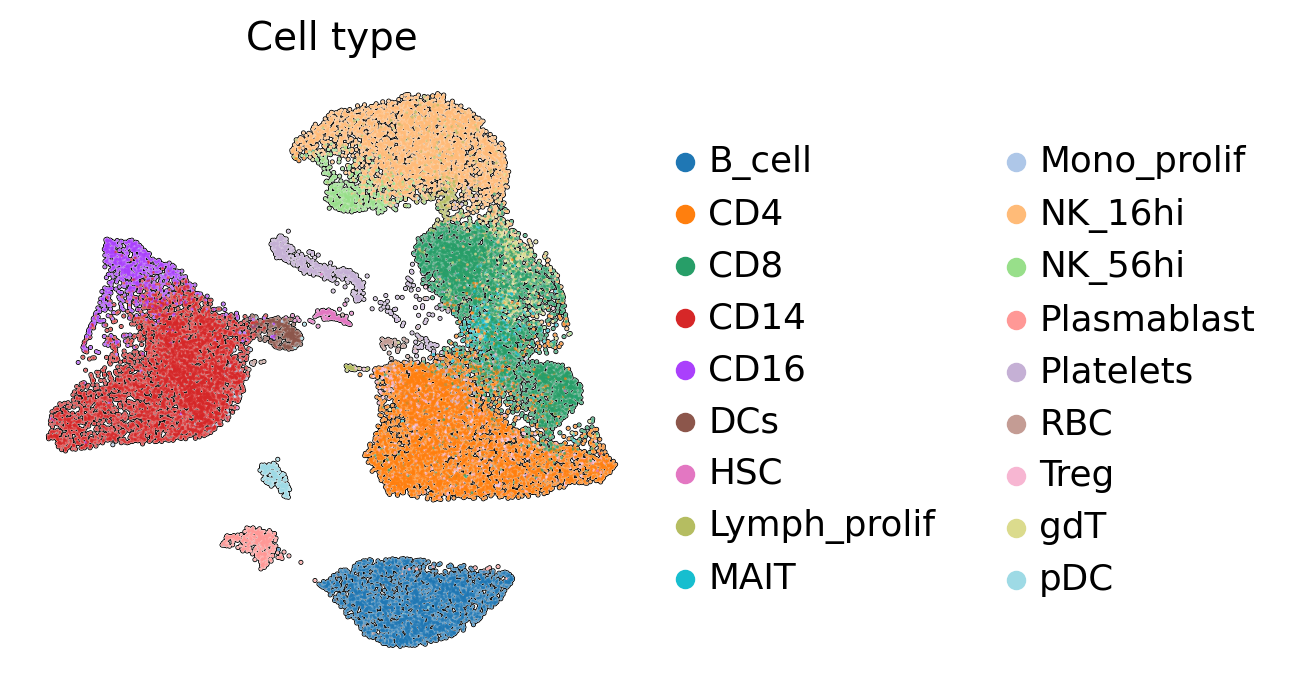

In [23]:
sc.pl.umap(adata_ss, color=['initial_clustering',]
           ,add_outline=True, title="Cell type")

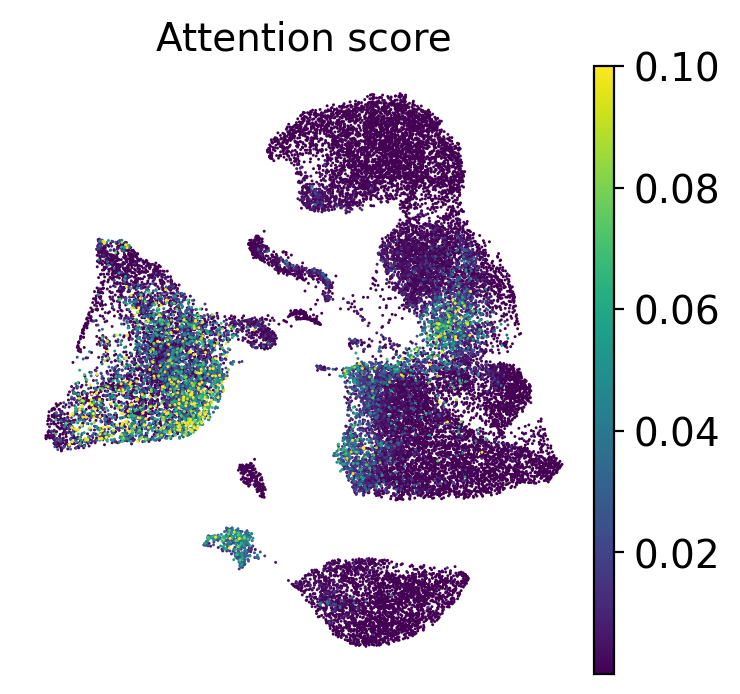

In [45]:
sc.pl.umap(adata_ss, color=['cell_attn'], vmax=.1,title="Attention score")

In [25]:
adata.obs.cell_attn = list(adata.obs.cell_attn)

In [109]:
df = adata.obs[["initial_clustering","Status_on_day_collection_summary","cell_attn"]]
# df = df.pivot_table(index='Status_on_day_collection_summary', columns='initial_clustering',values='cell_attn')

In [110]:
df_gp = df.groupby("initial_clustering")

In [111]:
df_mean = df_gp.mean()
df_mean.reset_index(level=0, inplace=True)

In [208]:
df_mean = df_mean.sort_values("cell_attn", ascending=False)

In [209]:
df_mean

,initial_clustering,cell_attn
9,Mono_prolif,0.040558
12,Plasmablast,0.034377
8,MAIT,0.023563
3,CD14,0.021756
16,gdT,0.016639
14,RBC,0.010905
4,CD16,0.007344
15,Treg,0.006184
1,CD4,0.005854
5,DCs,0.005423


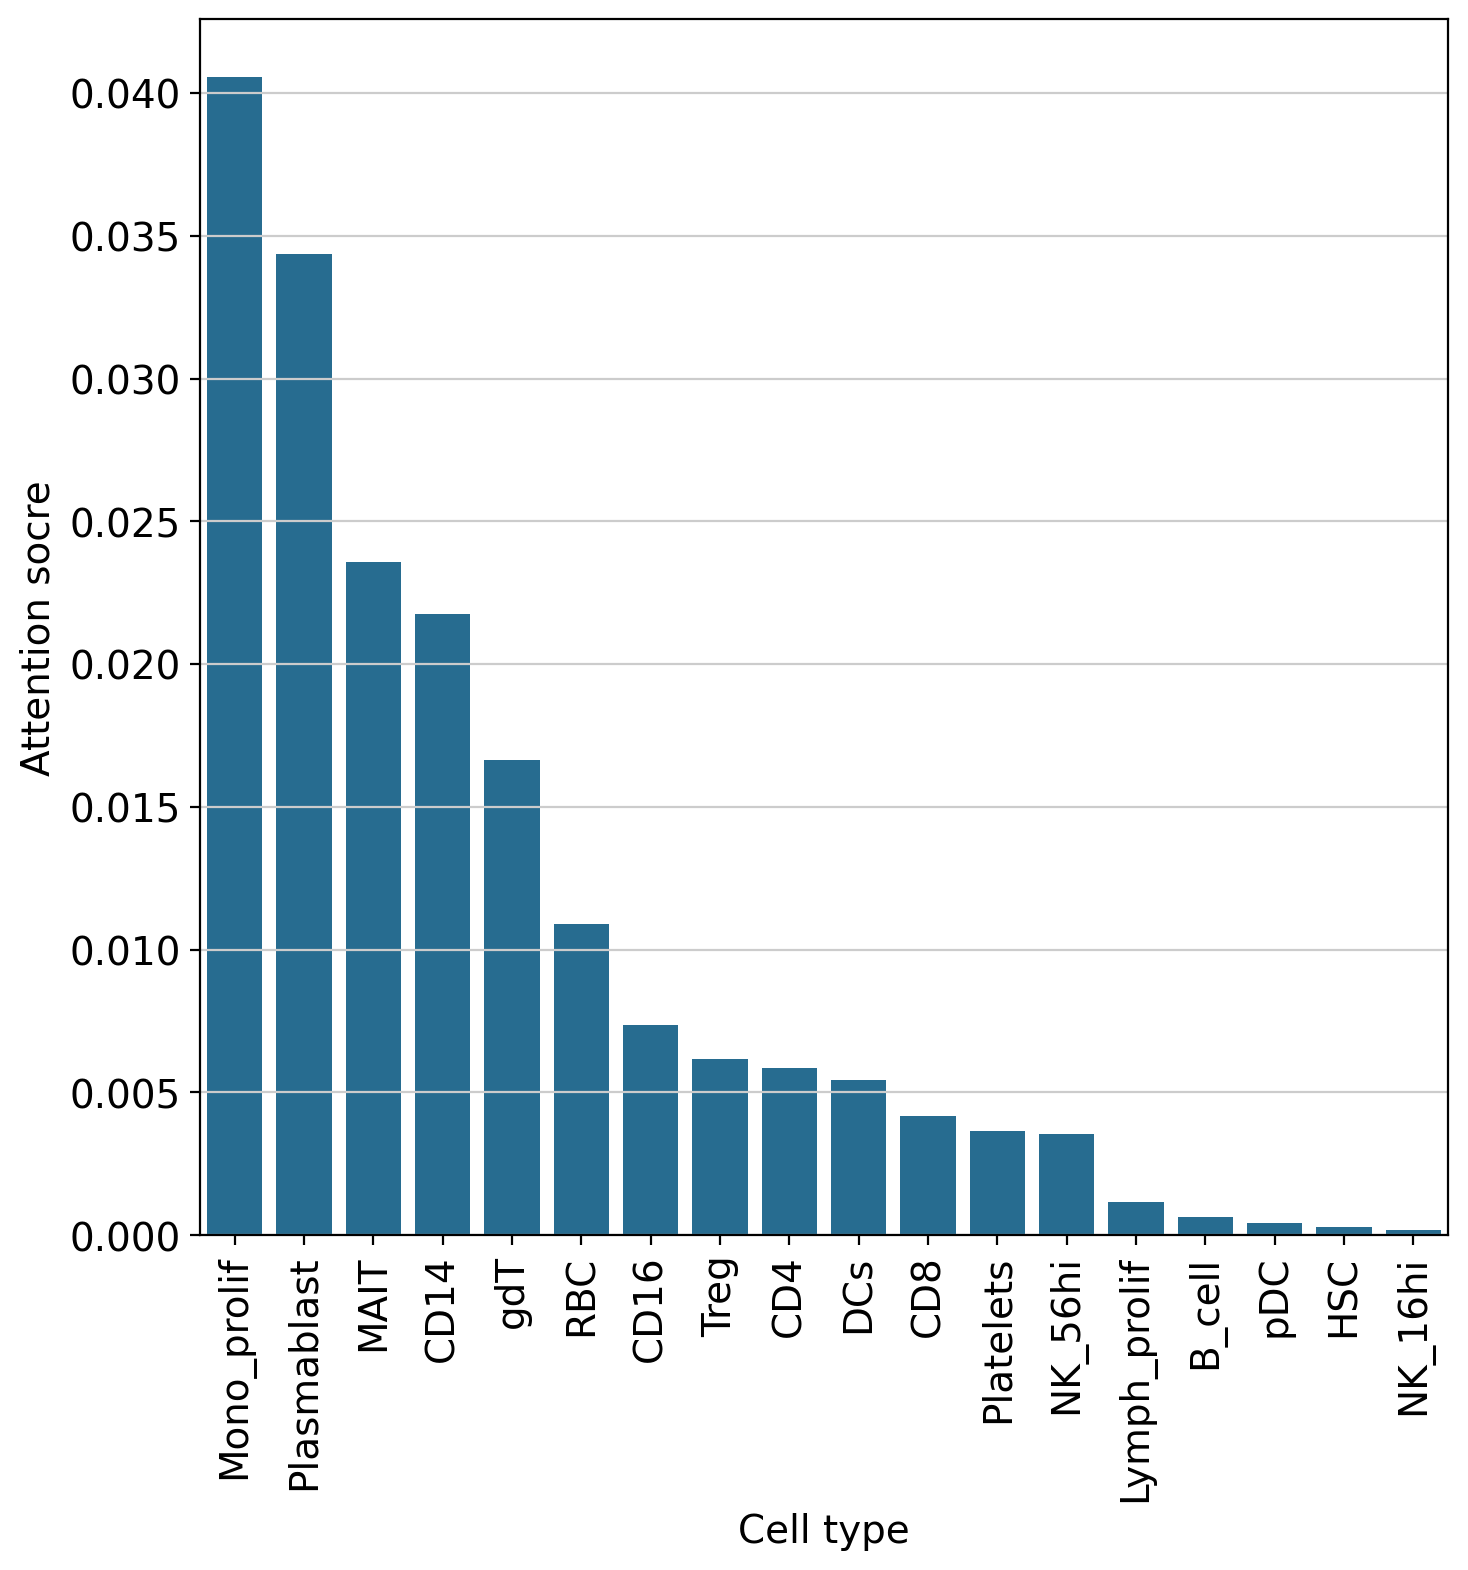

In [210]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
ax=  sns.barplot(x="initial_clustering", y="cell_attn", 
                 data=df_mean, color="#1572A1", order=list(df_mean["initial_clustering"]))
fig = ax.get_figure()
plt.ylabel("Attention socre")
plt.xlabel("Cell type")
fig.savefig("./figures/att_hanifa_ct.pdf")

In [116]:
GO_0034340 = pd.read_csv("./metadata/GO_0034340.txt")
GO_0034340 =  GO_0034340.to_numpy().flatten()

biger_list = pd.read_csv('./metadata/QuickGO-annotations-1643020023245-20220124.tsv', sep='\t')
biger_list = list(biger_list["SYMBOL"])

In [118]:
# df_mean = df.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()
df_mean = df.groupby(["initial_clustering"]).mean().reset_index()

In [119]:
top_att = df_mean[df_mean["cell_attn"] >= df_mean["cell_attn"].median()]

In [120]:
top_att= top_att.sort_values("cell_attn", ascending=False)["initial_clustering"].to_list()

In [121]:
top_att

['Mono_prolif',
 'Plasmablast',
 'MAIT',
 'CD14',
 'gdT',
 'RBC',
 'CD16',
 'Treg',
 'CD4']

In [122]:
bot_att = df_mean[df_mean["cell_attn"] < df_mean["cell_attn"].median()]
bot_att = bot_att.sort_values("cell_attn", ascending=True)["initial_clustering"].to_list()

In [123]:
bot_att

['NK_16hi',
 'HSC',
 'pDC',
 'B_cell',
 'Lymph_prolif',
 'NK_56hi',
 'Platelets',
 'CD8',
 'DCs']

### Gene score analysis om the full data

In [47]:
adata_origi = sc.read("./data/haniffa21.processed.h5ad")

In [48]:
adata_origi = adata_origi[~adata_origi.obs.Status_on_day_collection_summary.isin(["Non_covid","LPS_90mins","LPS_10hours"])]

In [166]:
sc.tl.score_genes(adata_origi,GO_0034340,)
sc.tl.score_genes(adata_origi,biger_list, score_name="biger_list")

In [167]:
df_full = adata_origi.obs[["initial_clustering","Status_on_day_collection_summary","score","biger_list"]]


In [168]:
df_mean_full = df_full.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()

In [169]:
# df_mean_full_ss = df_mean_full[df_mean_full.initial_clustering.isin(np.unique(top_att))]

In [170]:
df_mean_full_ss = df_mean_full[df_mean_full.initial_clustering.isin(np.unique(adata.obs.initial_clustering))]

In [171]:
df_mean_full_ss.initial_clustering = df_mean_full_ss.initial_clustering.cat.remove_unused_categories()

Computing LFC socres

In [172]:
order = ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]

In [173]:
heatlhy_df = df_mean_full_ss[df_mean_full_ss.Status_on_day_collection_summary == "Healthy"]
non_heatlhy_df = df_mean_full_ss[df_mean_full_ss.Status_on_day_collection_summary != "Healthy"]


In [174]:
for index, row in non_heatlhy_df.iterrows():
       ctrl = heatlhy_df[heatlhy_df.initial_clustering == f"{row['initial_clustering']}"]["score"]
       non_heatlhy_df.loc[index]["score"] = np.log2(row['score']) - np.log2(ctrl)
for index, row in non_heatlhy_df.iterrows():
    ctrl = heatlhy_df[heatlhy_df.initial_clustering == f"{row['initial_clustering']}"]["biger_list"]
    non_heatlhy_df.loc[index]["biger_list"] = np.log2(row['biger_list']) - np.log2(ctrl)

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scoring using  smaller list from https://www.gsea-msigdb.org/gsea/msigdb/cards/GOBP_RESPONSE_TO_TYPE_I_INTERFERON.html

## averaging score over all condition to compute on score for each celltype

In [199]:
overal = non_heatlhy_df.groupby("initial_clustering").mean()
overal = overal.reset_index()

In [ ]:
overal = overal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


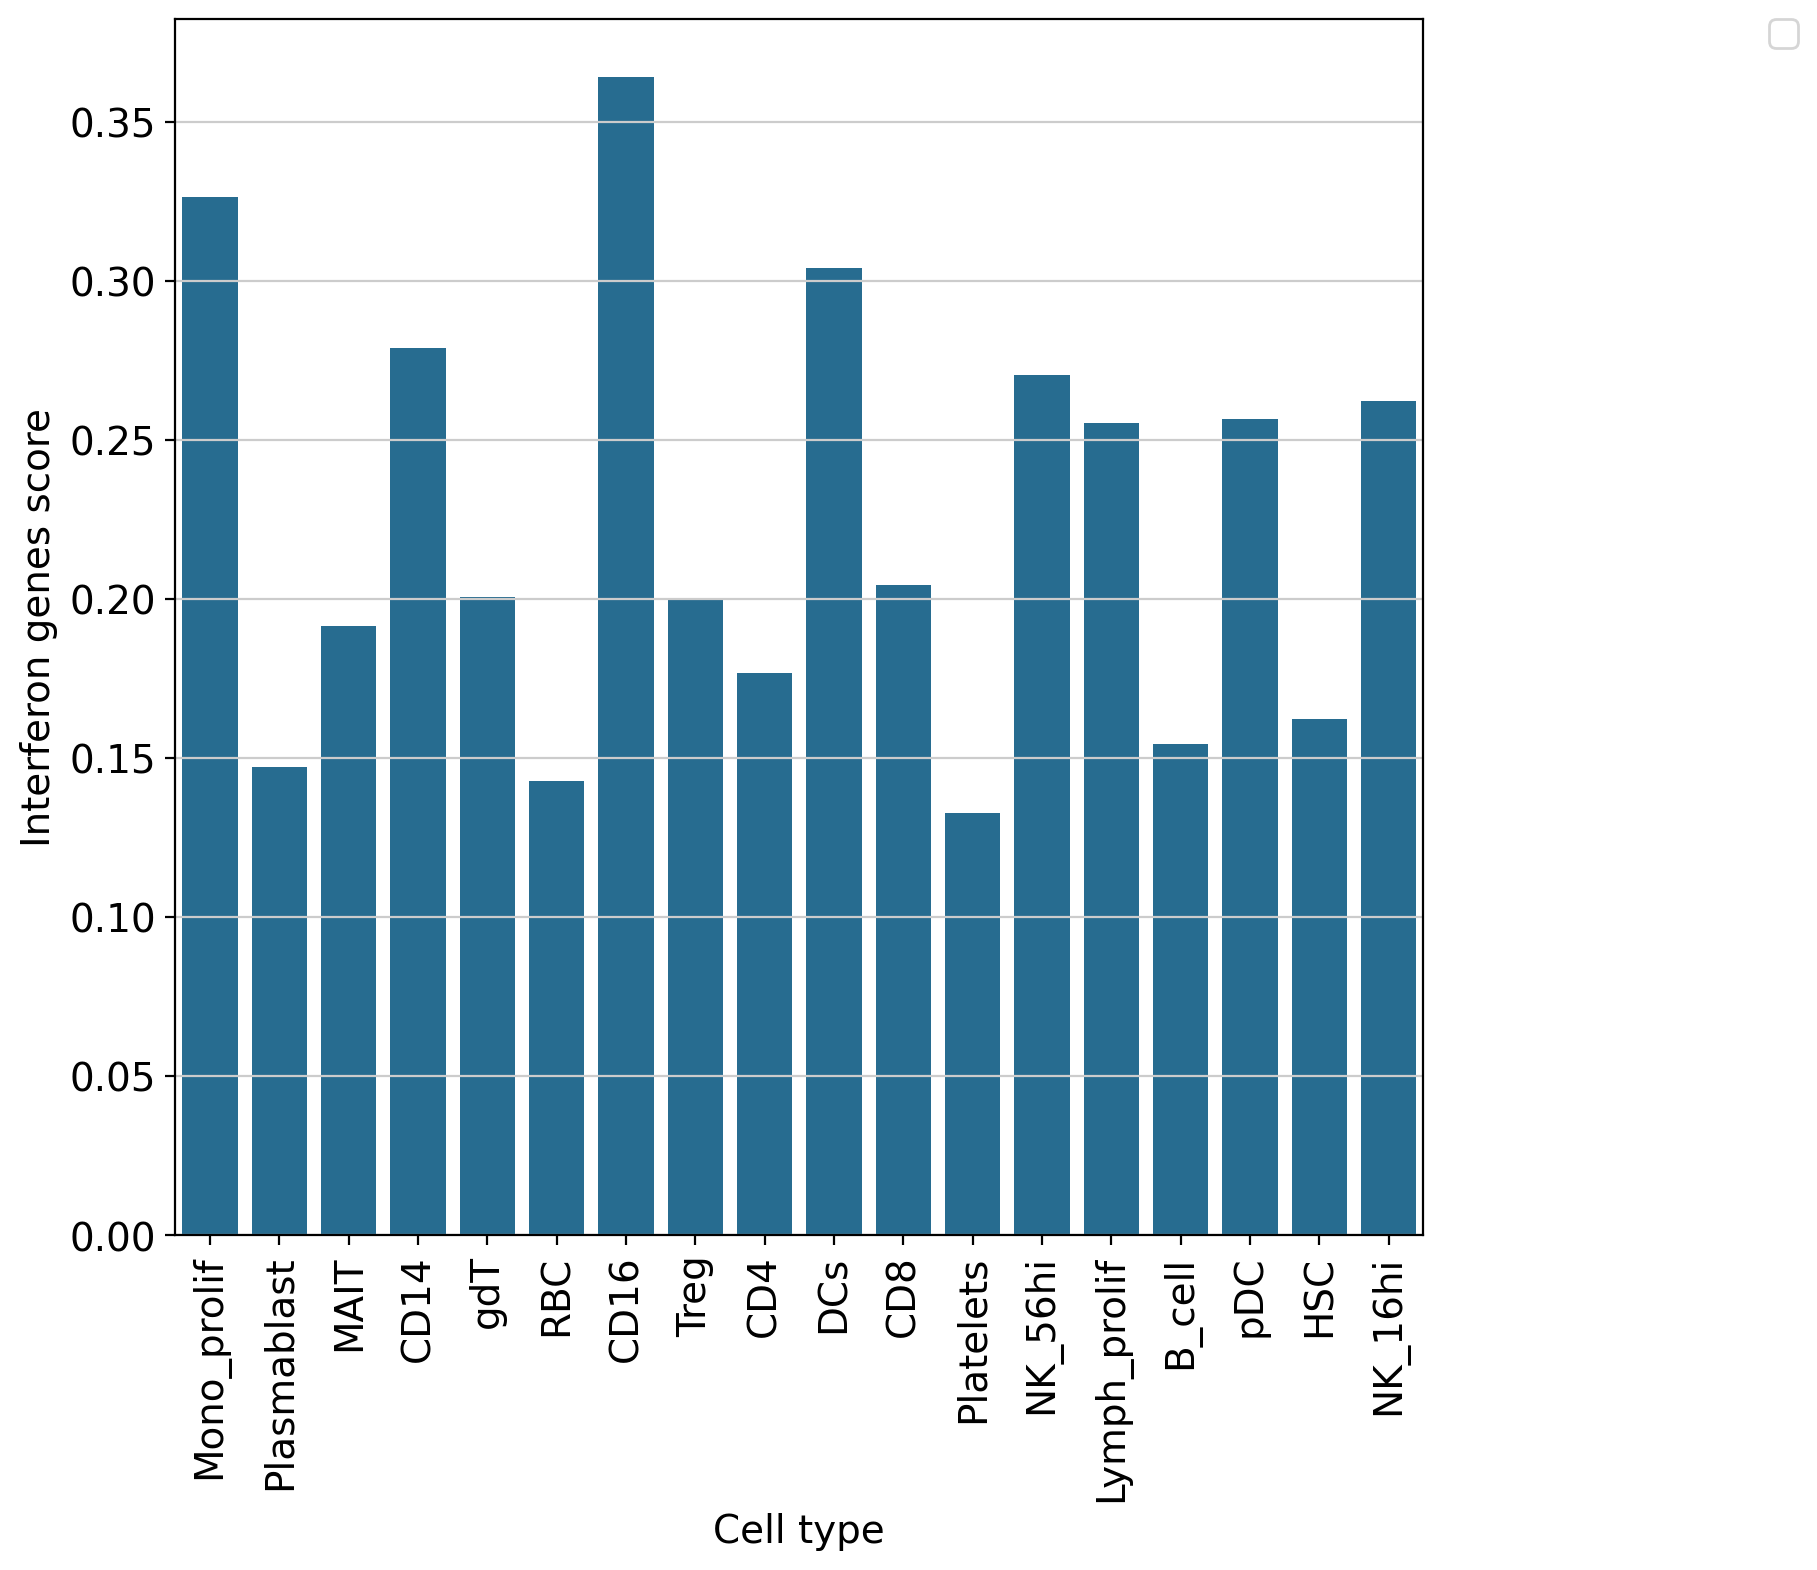

In [211]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= overal,
            hue_order=order, color="#1572A1", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


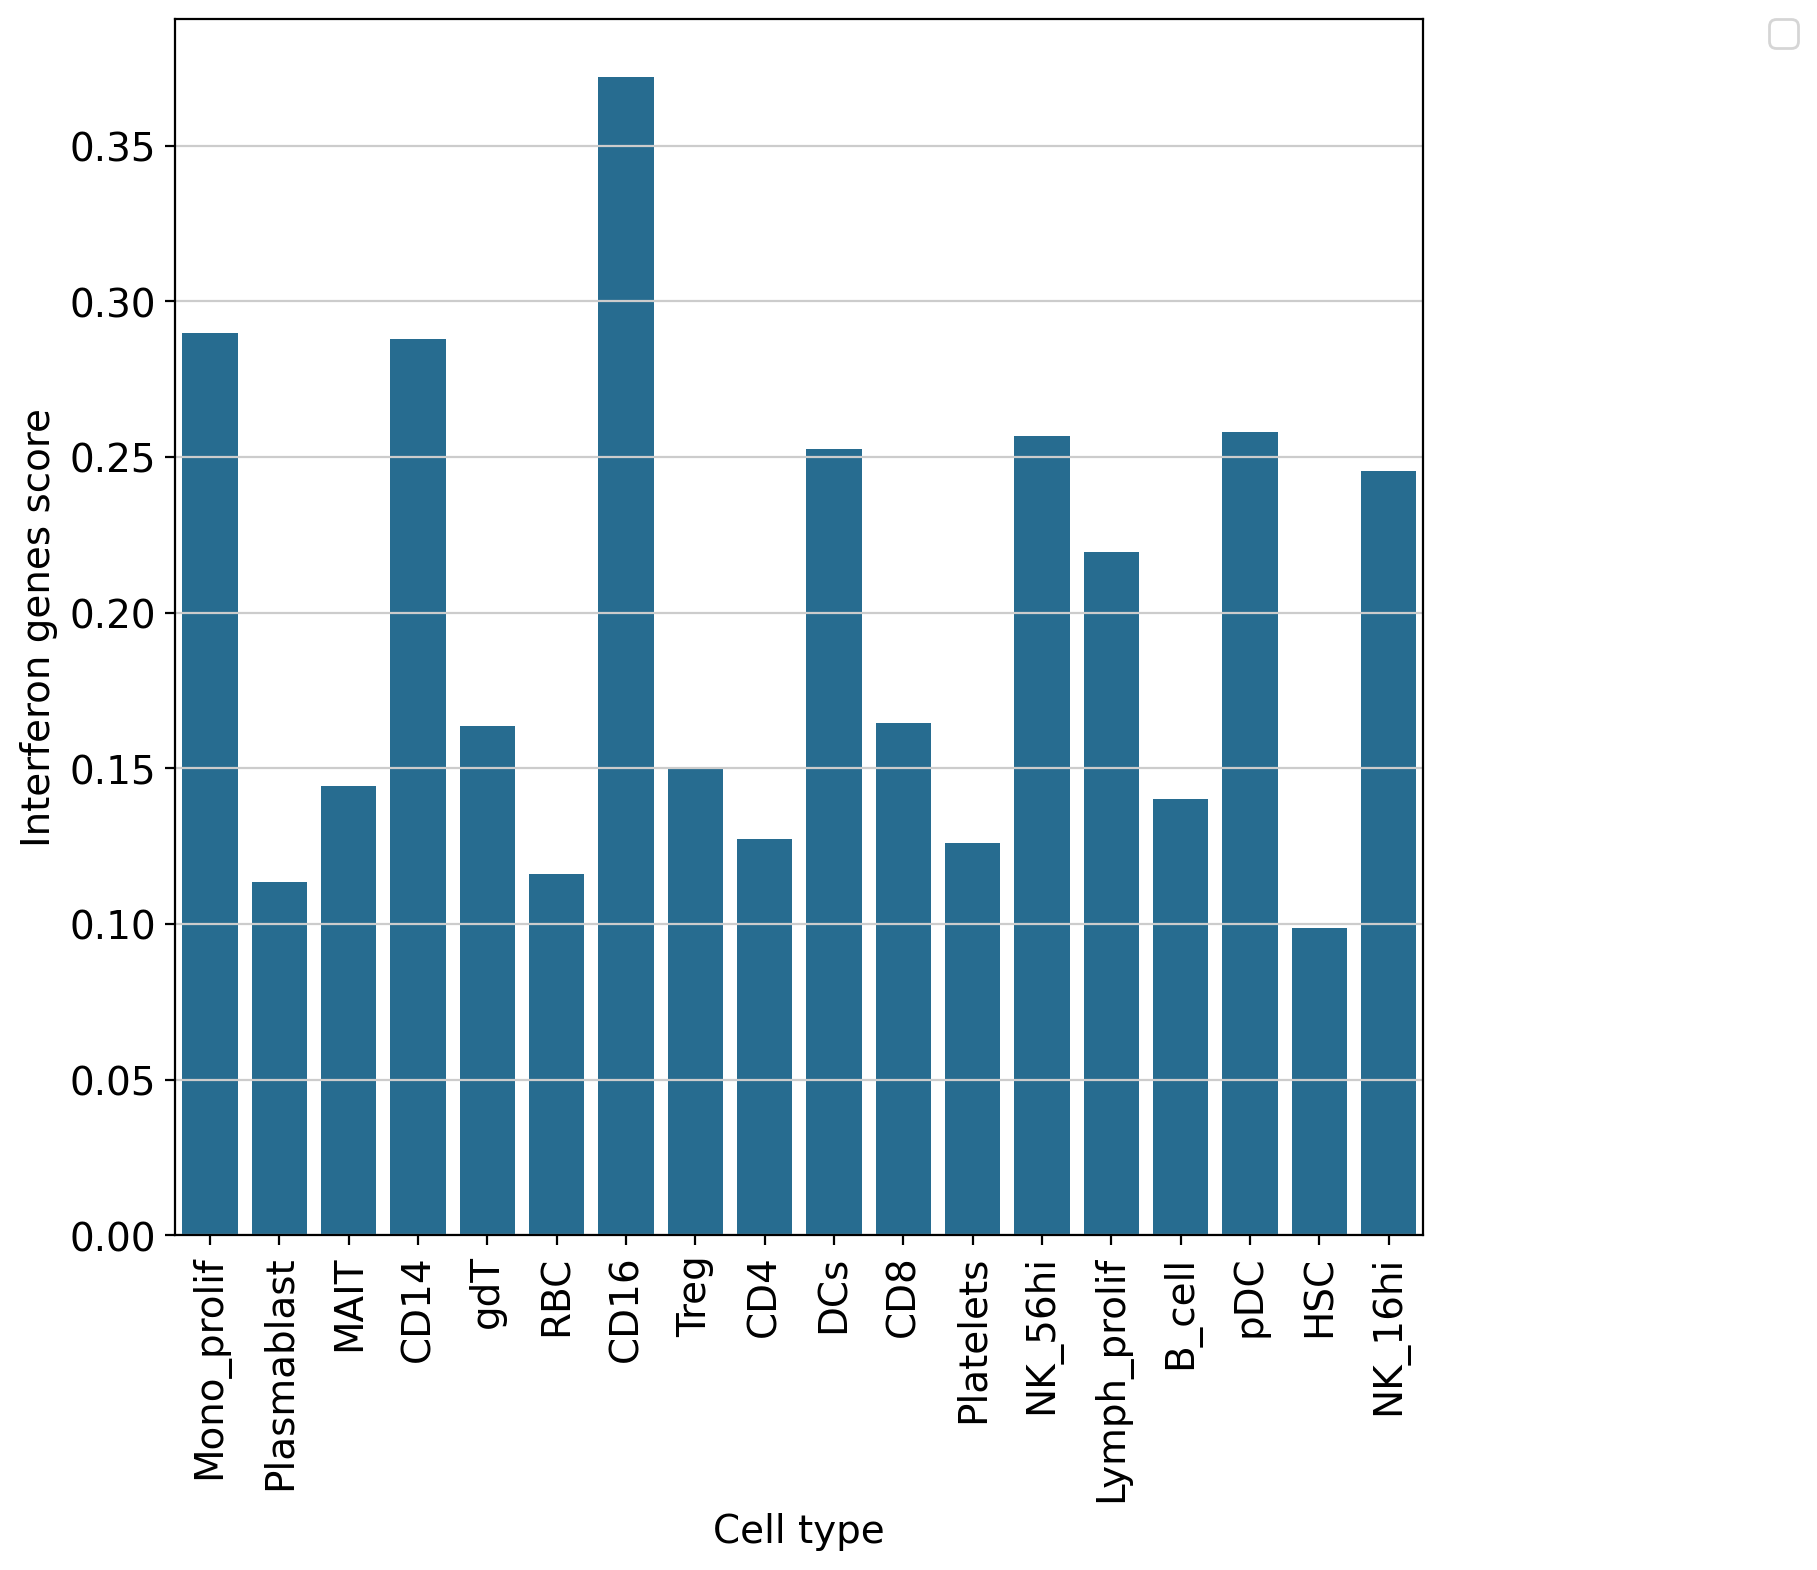

In [212]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= overal,
            hue_order=order, color="#1572A1", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

## viusalizng  scores per condition 

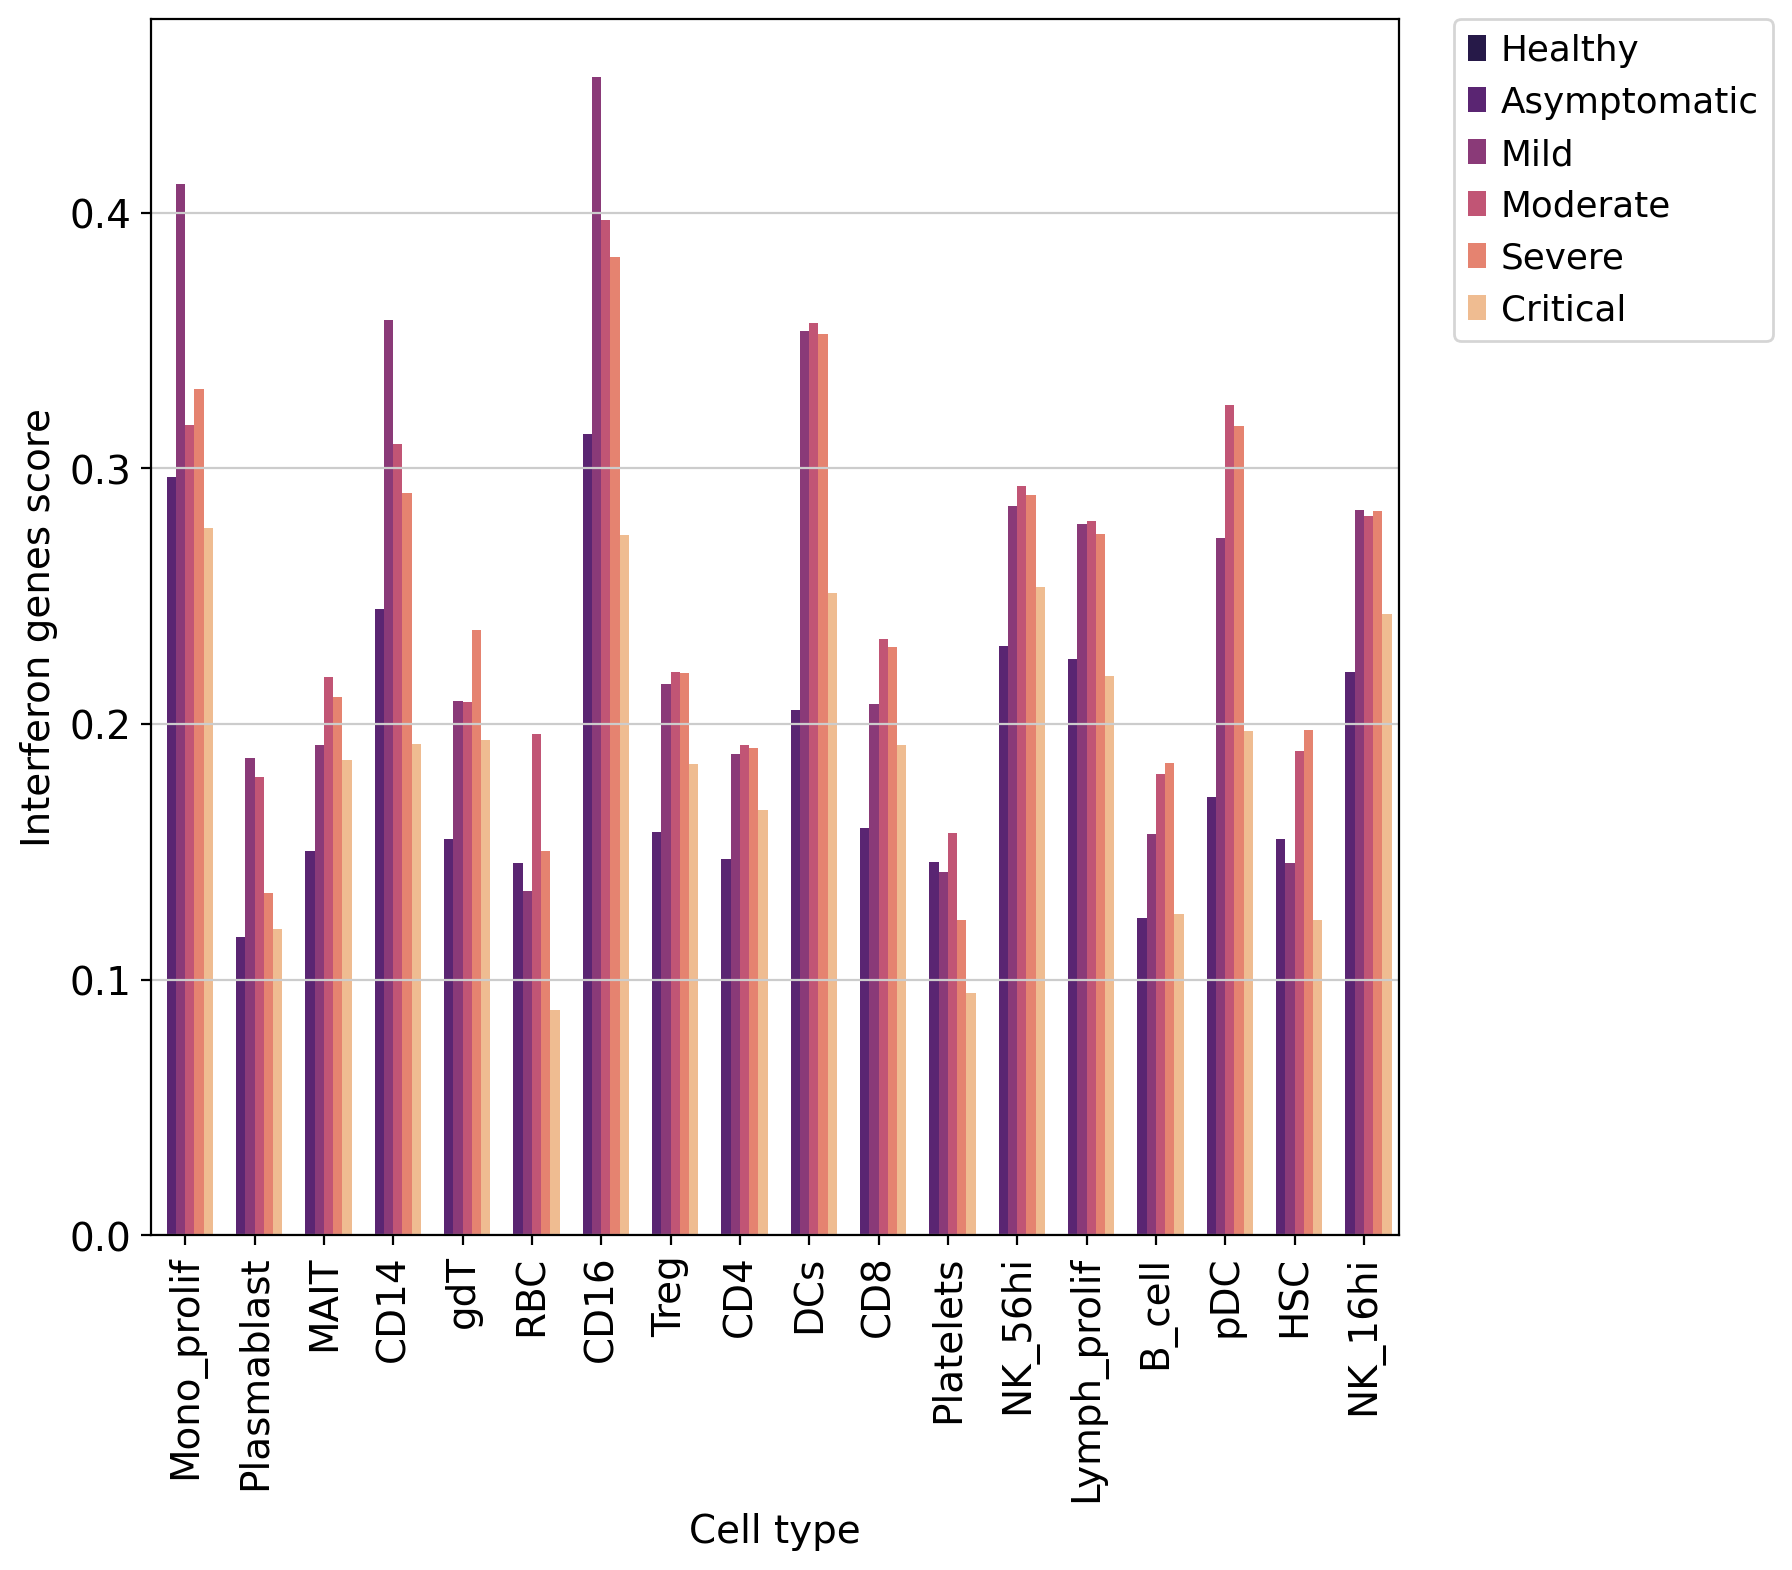

In [213]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= non_heatlhy_df, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

Scoring using  bigger list from https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0034340&taxonId=9606&taxonUsage=descendants#:~:text=1000-,Go,-243%20annotations

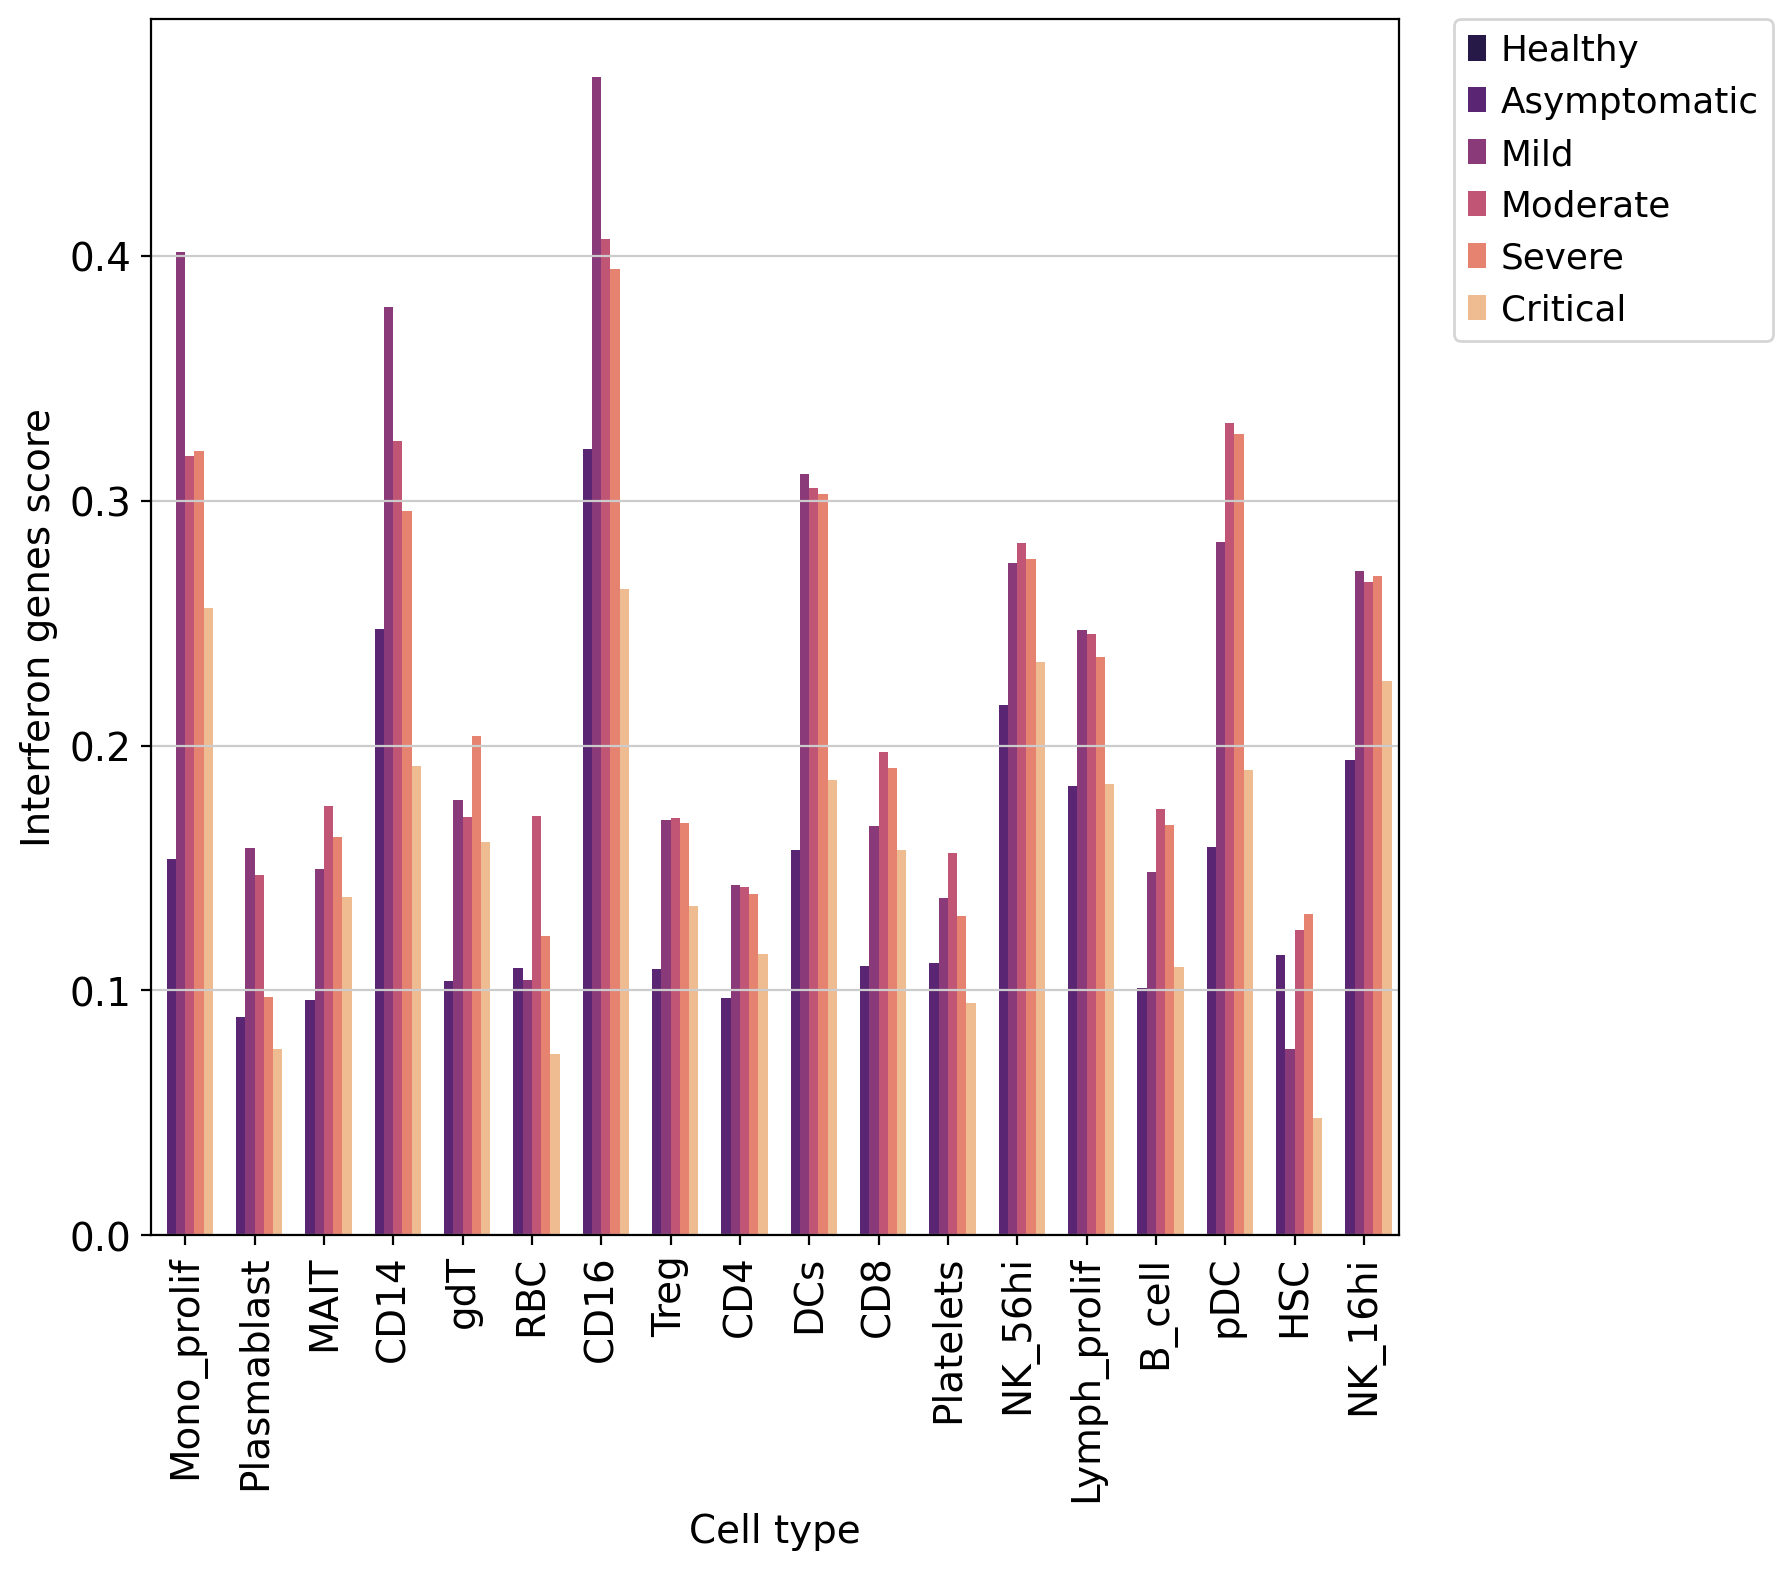

In [214]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= non_heatlhy_df, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

## accounting score for healthy too

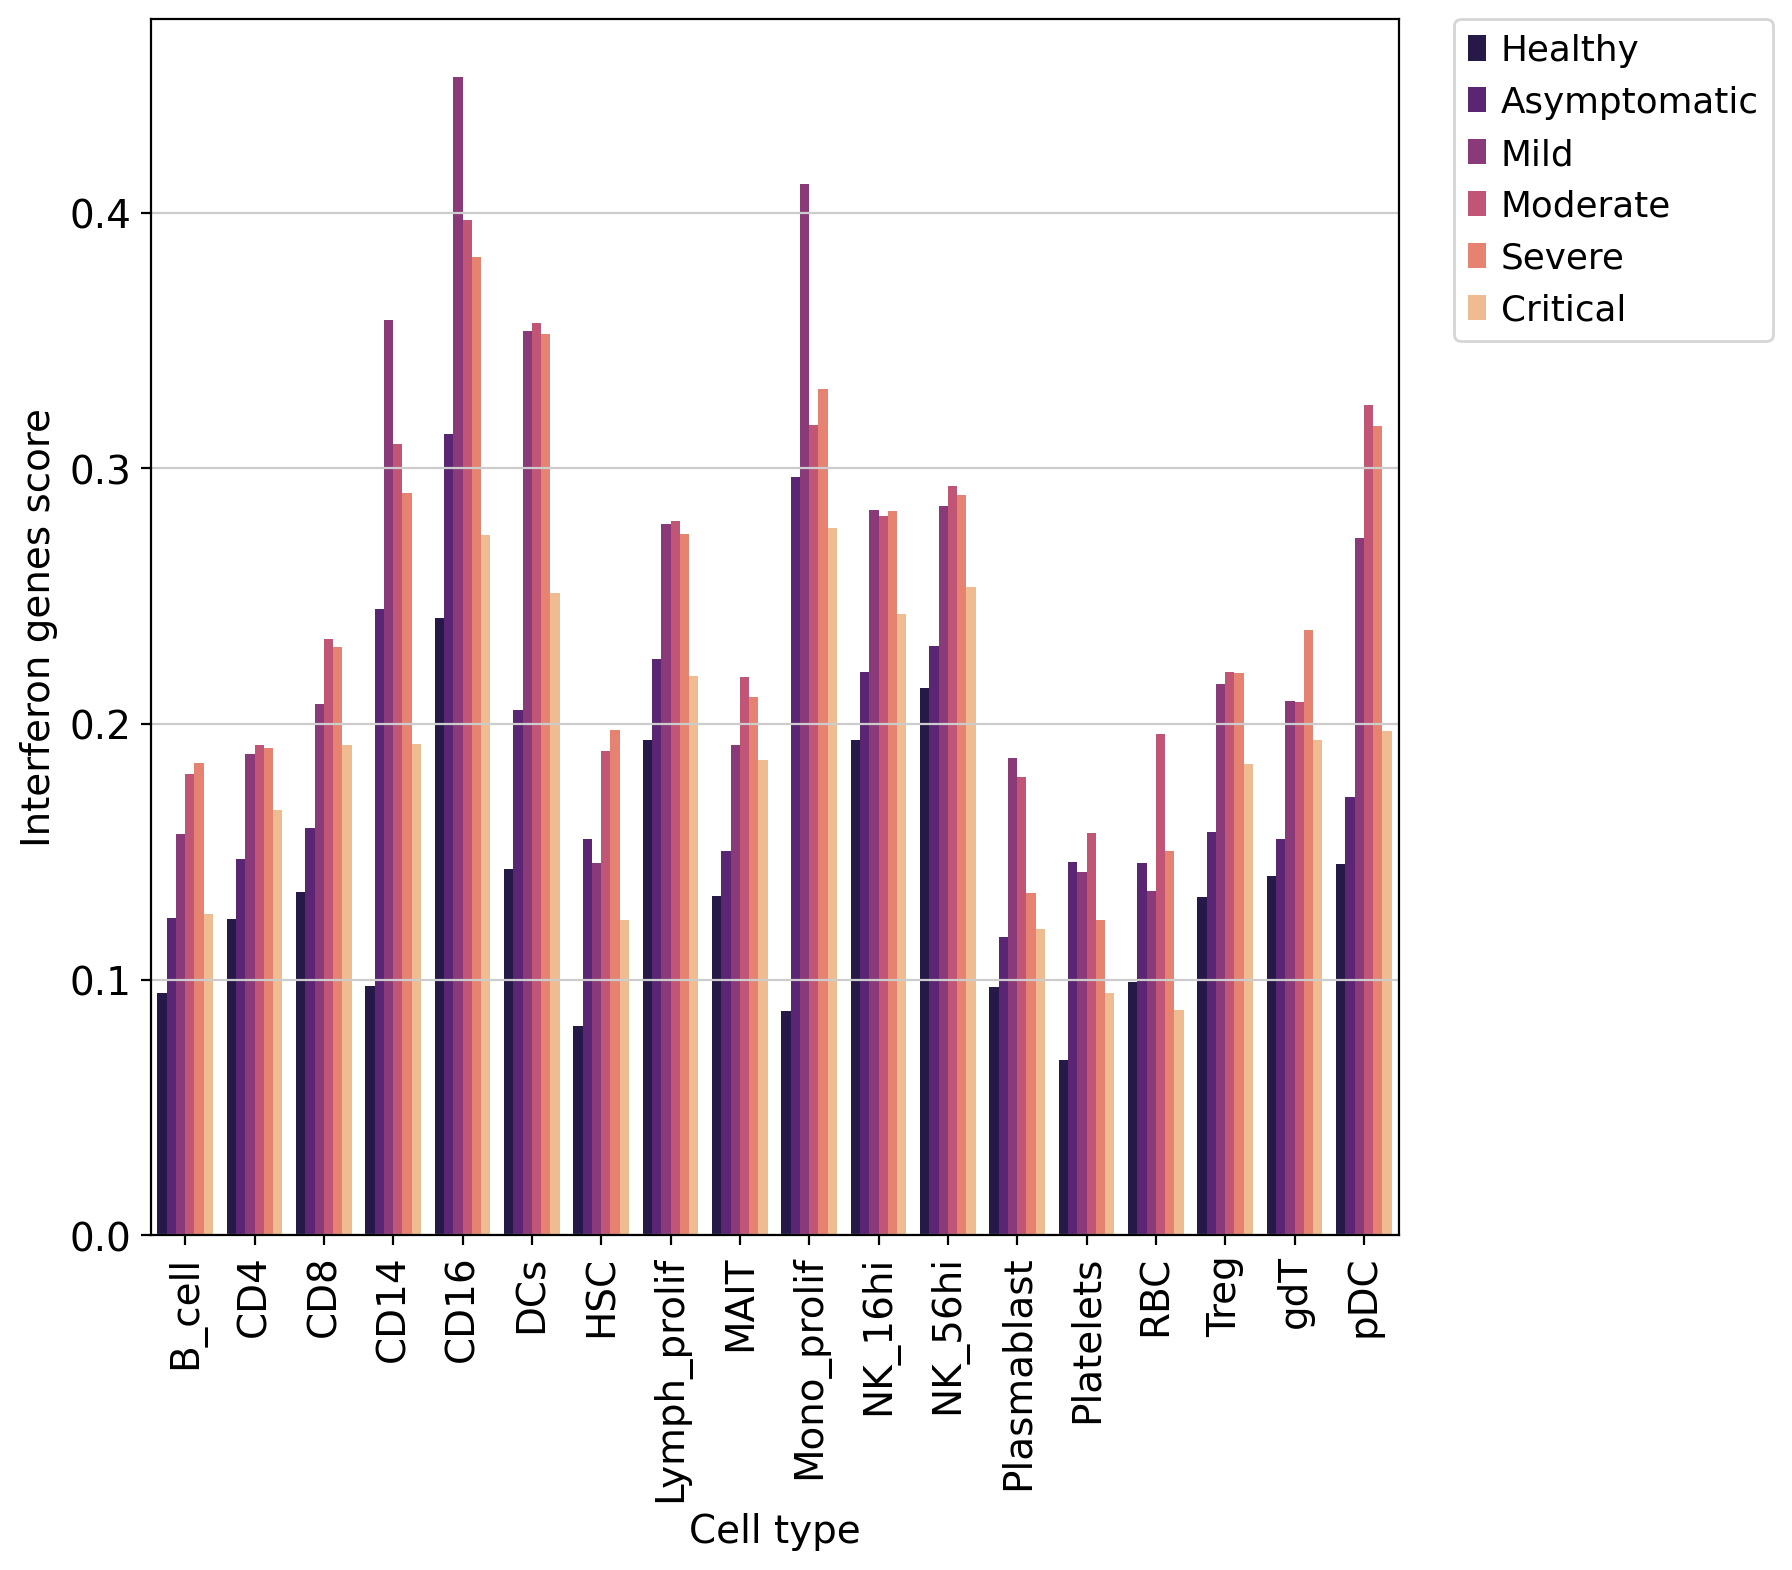

In [215]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= df_mean_full_ss, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", )
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_full.pdf")

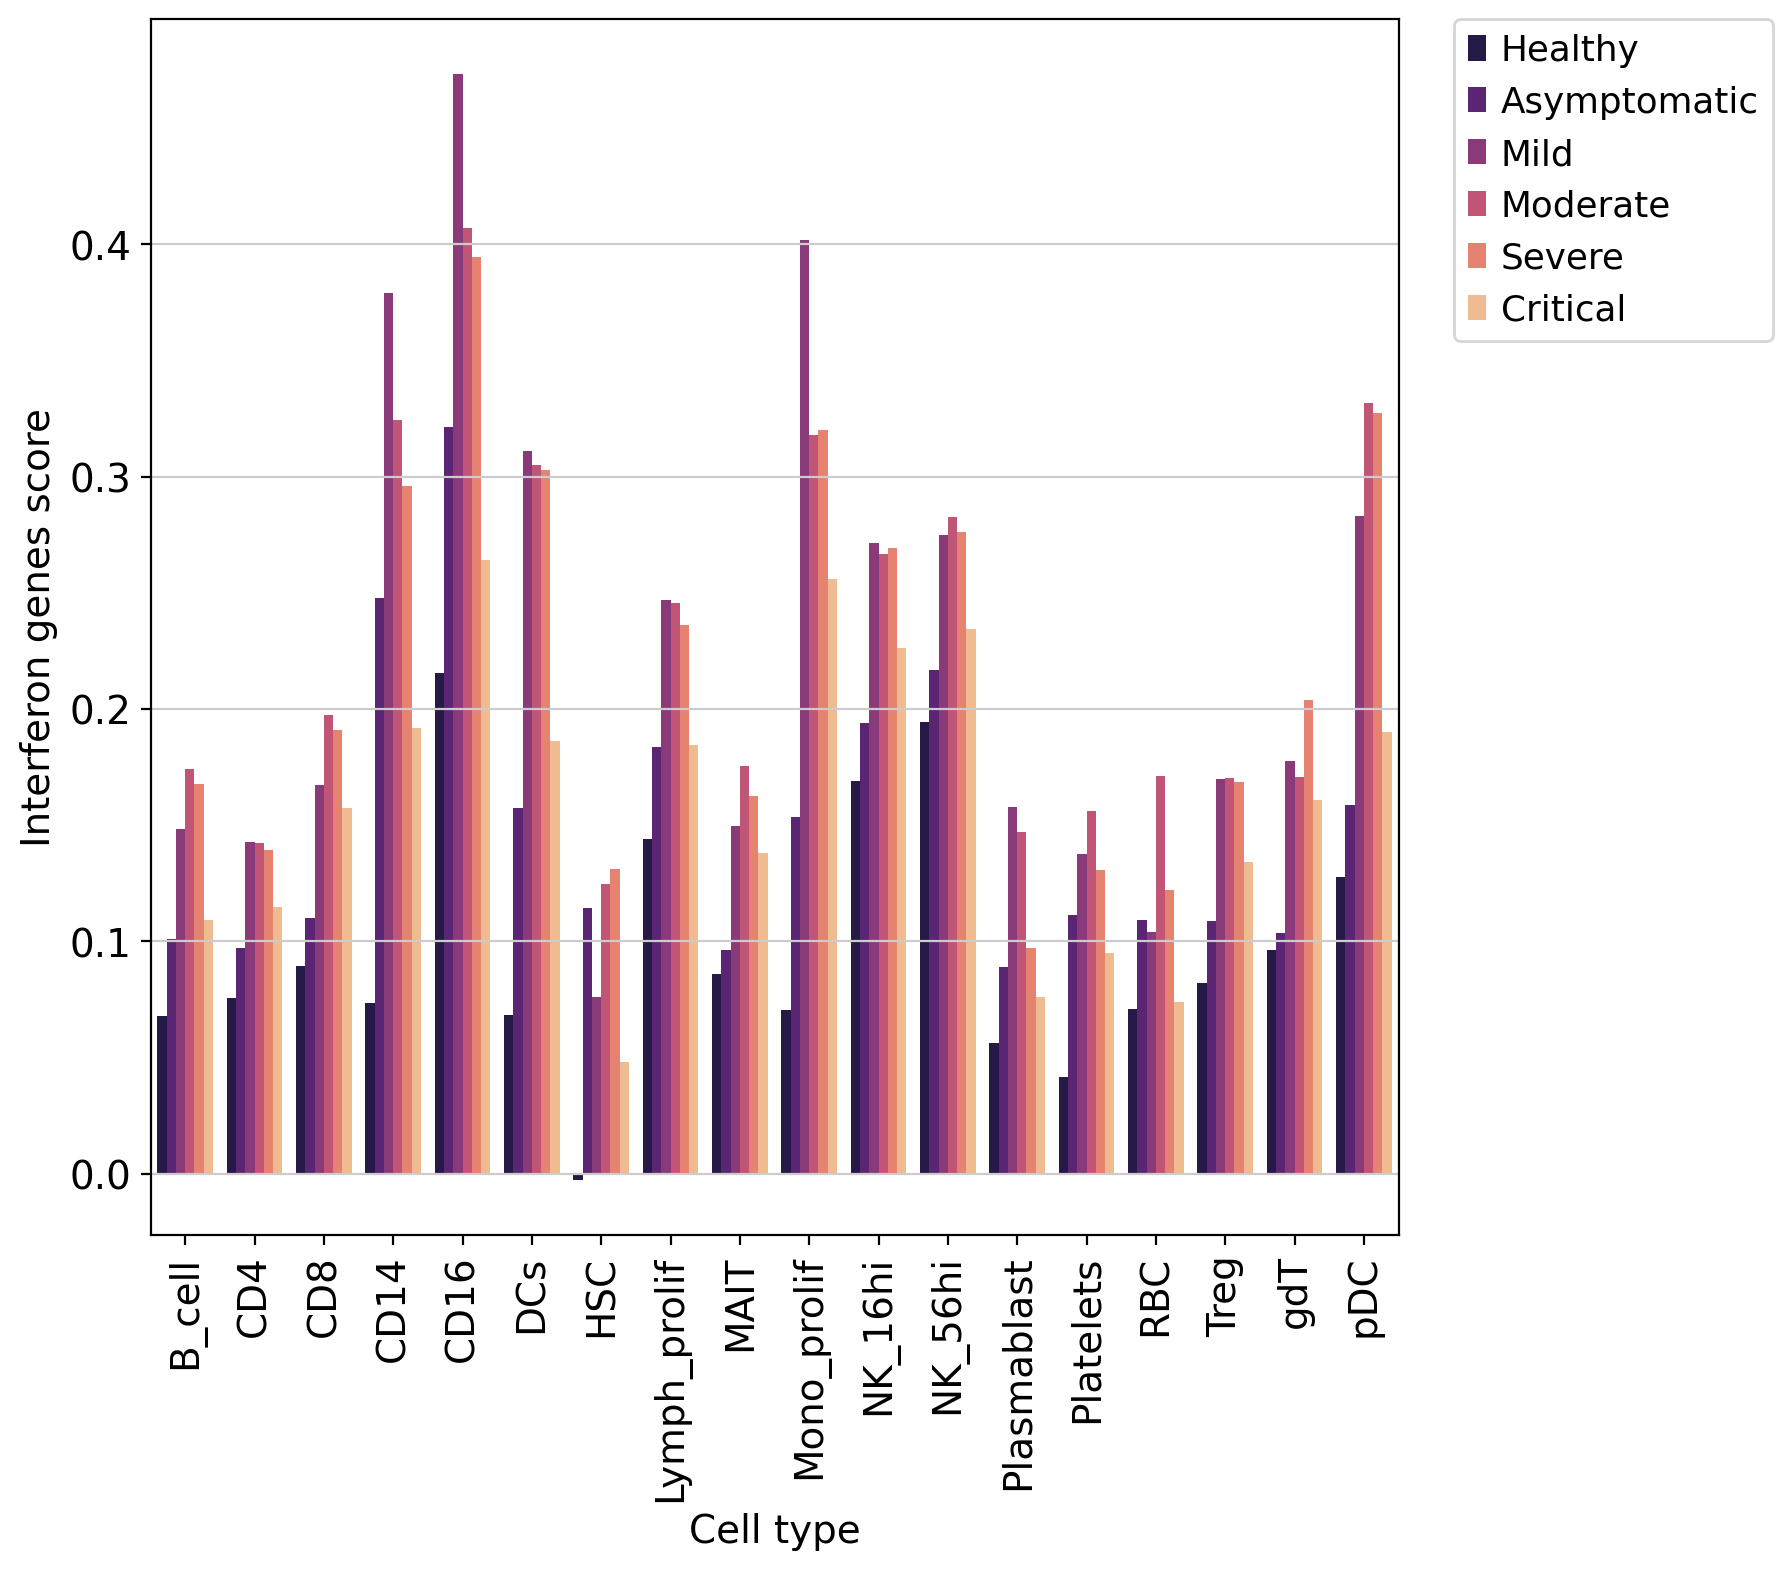

In [216]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= df_mean_full_ss, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", )
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_full.pdf")

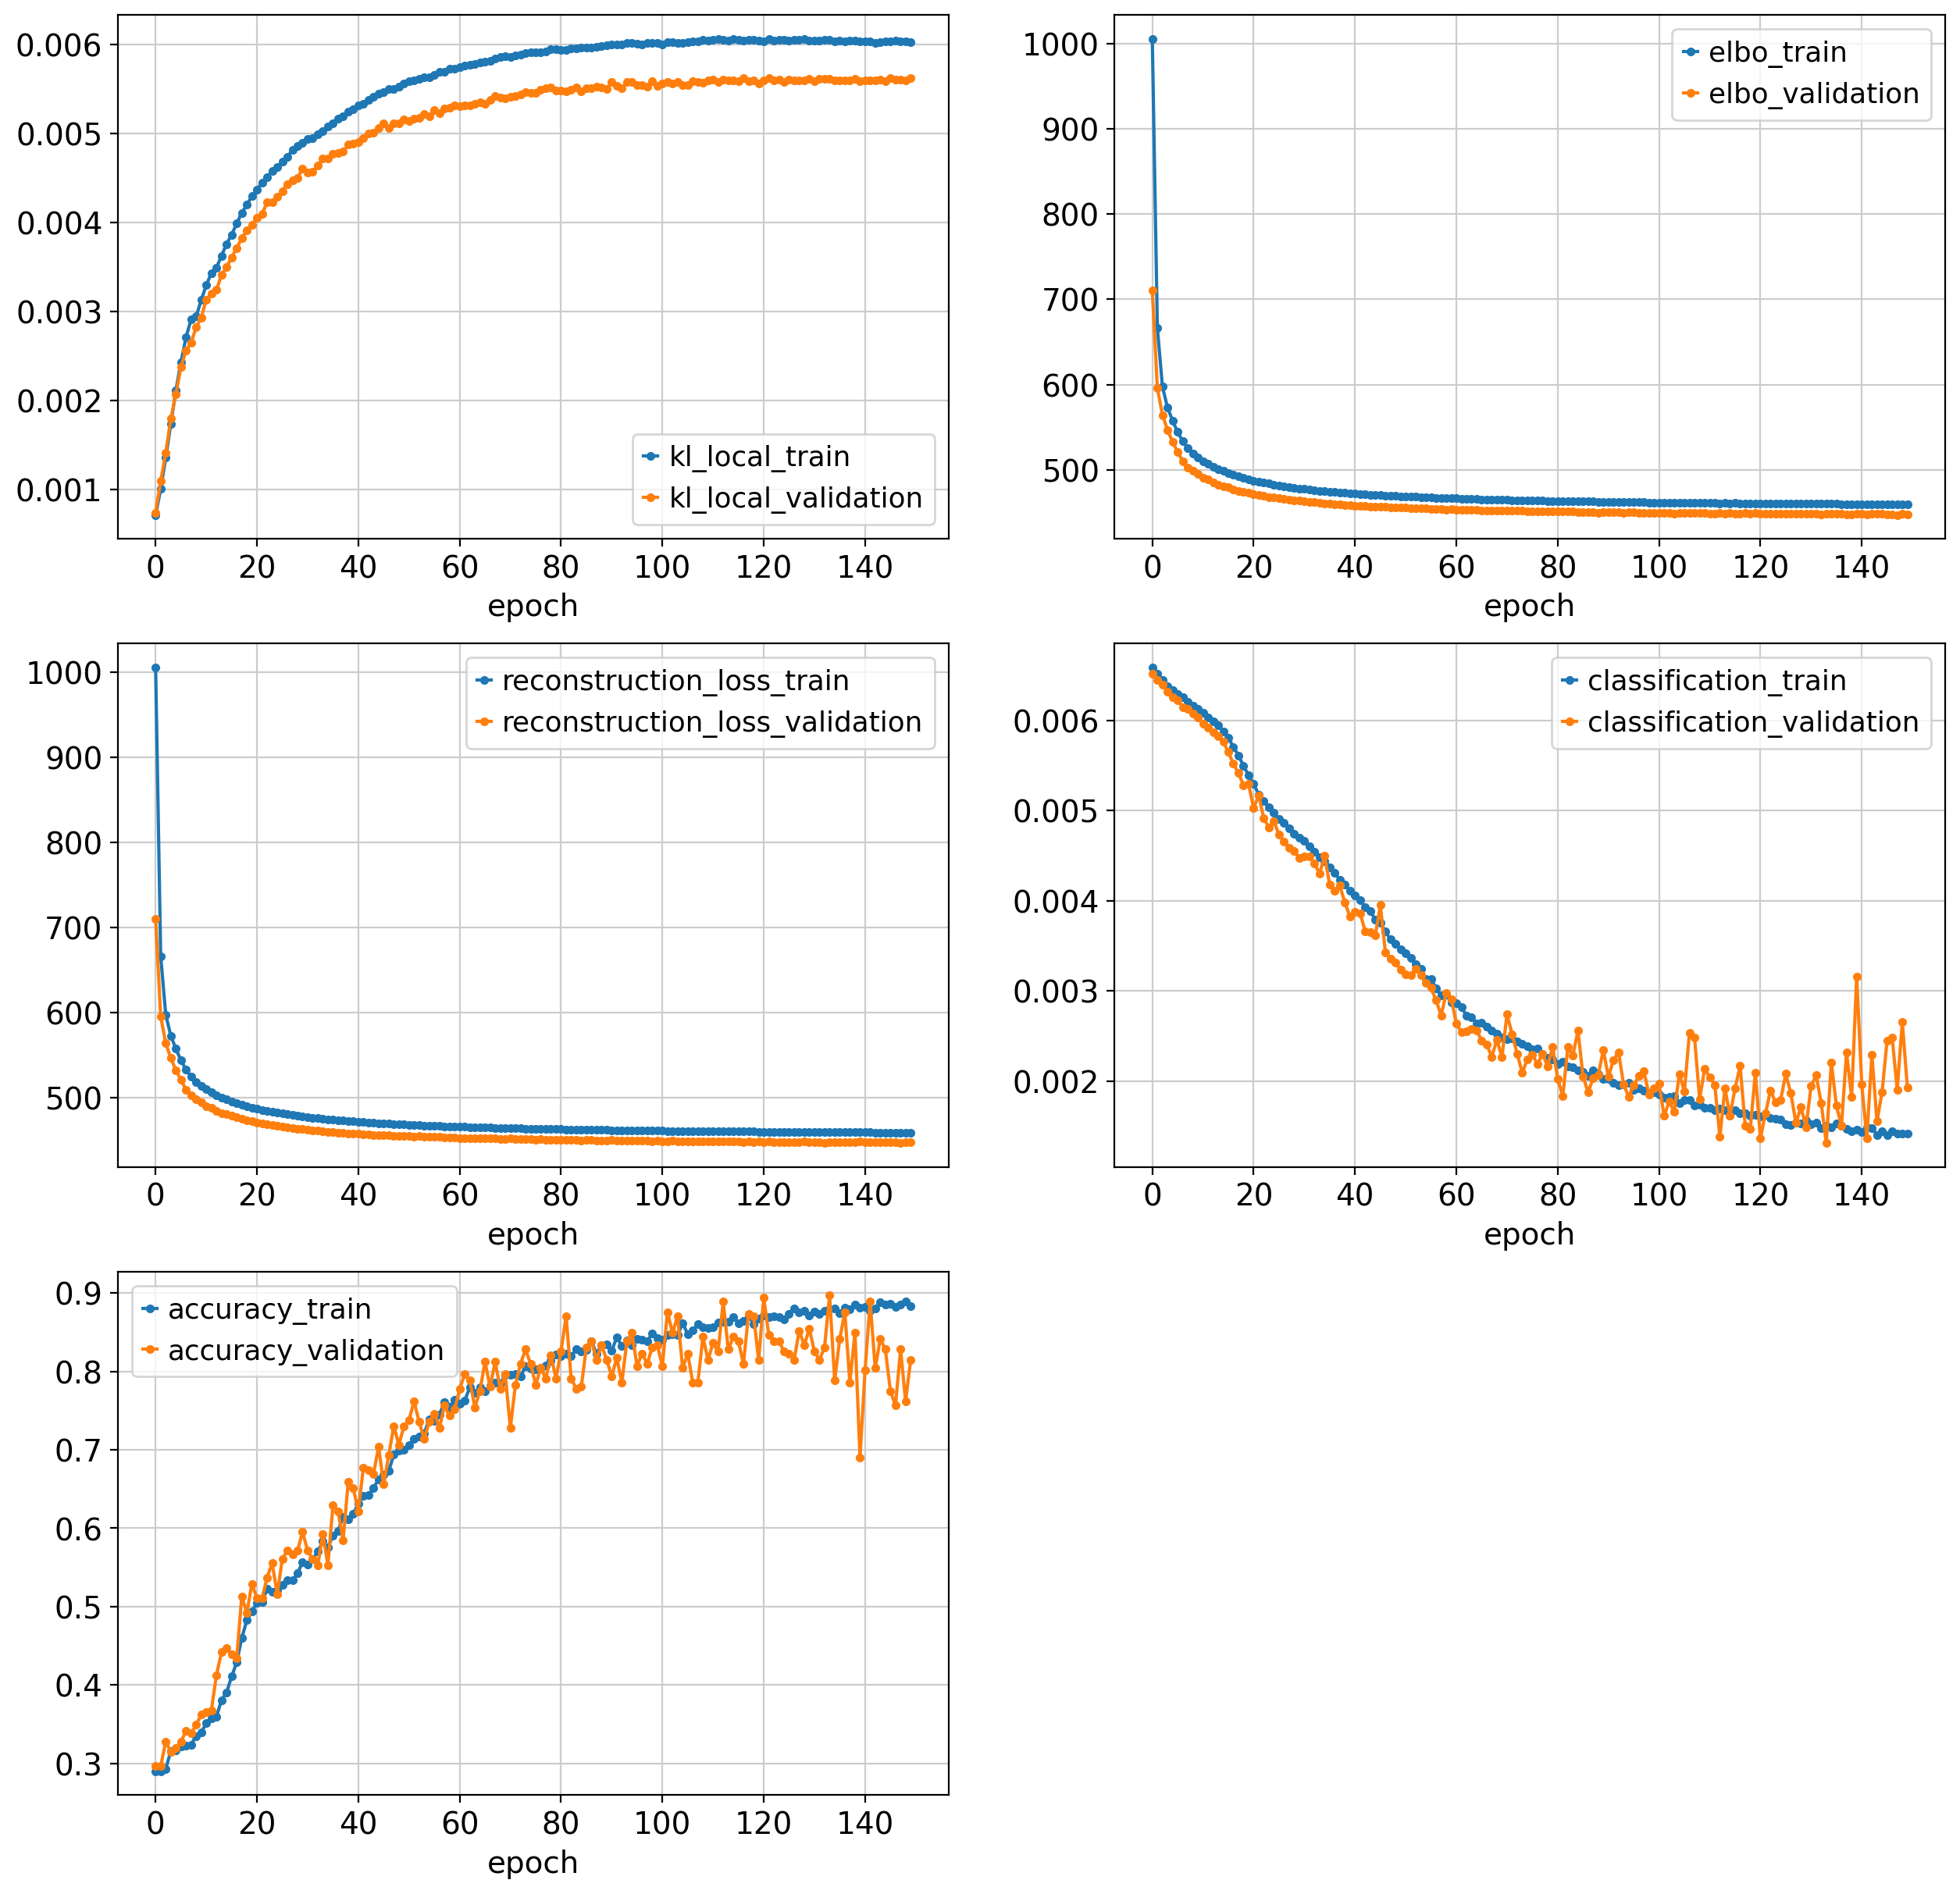

In [63]:
# df = pd.DataFrame(mil.history['train_loss_step'])
# for key in mil.history.keys():
#     if key != 'train_loss_step':
#         df = df.join(mil.history[key])

# df['epoch'] = df.index

# plt.figure(figsize=(15, 15))
# loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'classification', 'accuracy']
# nrows = 3

# for i, name in enumerate(loss_names):
#     plt.subplot(nrows, 2, i+1)
#     plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
#     plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')
#     plt.xlabel('epoch')
#     plt.legend()